In [1]:
"""
This notebook will allow you to train or run a model on an individual modality
"""
import torch
import numpy as np
import torch.optim as optim
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
from sklearn.metrics import roc_auc_score
import datetime
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from io import StringIO
import os
import ffmpeg
import pdb
from functions import create_pytorch_dataset
from functions import get_total_performance_metrics
from functions import get_performance_metrics
from functions import get_global_performance_metrics
from functions import get_window_metrics
from functions import get_frame_metrics
from functions import animate


Train Dataloader - 48
Test Dataloader - 173
Device Used - cuda
Training has Begun
epoch [1/20], loss:0.0010
epoch [2/20], loss:0.0004
epoch [3/20], loss:0.0003
epoch [4/20], loss:0.0003
epoch [5/20], loss:0.0002
epoch [6/20], loss:0.0002
epoch [7/20], loss:0.0002
epoch [8/20], loss:0.0002
epoch [9/20], loss:0.0002
epoch [10/20], loss:0.0001
epoch [11/20], loss:0.0001
epoch [12/20], loss:0.0001
epoch [13/20], loss:0.0001
epoch [14/20], loss:0.0001
epoch [15/20], loss:0.0001
epoch [16/20], loss:0.0001
epoch [17/20], loss:0.0001
epoch [18/20], loss:0.0001
epoch [19/20], loss:0.0001


c:\Users\abdul\anaconda3\envs\fyp_base_paper_2\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


epoch [20/20], loss:0.0001
Training has Completed
foward pass occuring
Thermal_T32024-01-28-20-09-06
----------------------------------
STD Global Classification Results
TPR 0.904, FPR 0.368, Precision 0.038, Recall 0.904
tn 41947, fp 24442, fn 103, tp 969
std_AUROC  0.805
----------------------------------
----------------------------------
Mean Global Classification Results
TPR 0.917, FPR 0.393, Precision 0.036, Recall 0.917
tn 40296, fp 26093, fn 89, tp 983
mean_AUROC 0.818
----------------------------------


d:\Abdul Rasheed NITT\Academics\Eigth Semester\FYP\Base Paper\Implementation\FallDetection\SampleCode\functions.py:225: RuntimeWarning: Mean of empty slice
  final_performance_mean = np.nanmean(video_metrics, axis=0) # get the mean performance across all videos
c:\Users\abdul\anaconda3\envs\fyp_base_paper_2\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


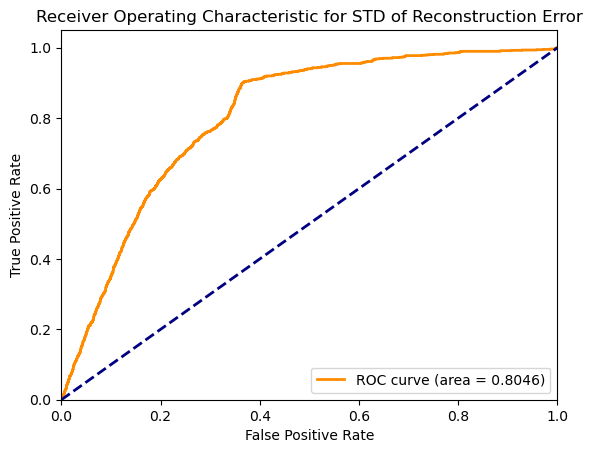

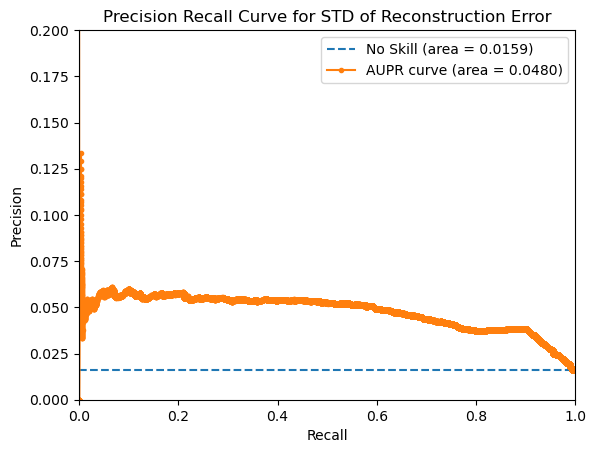

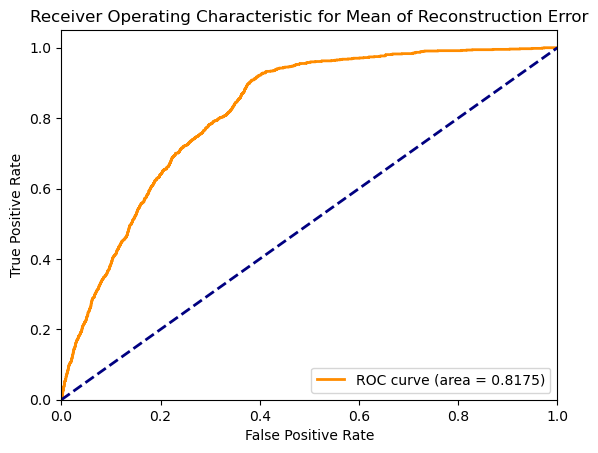

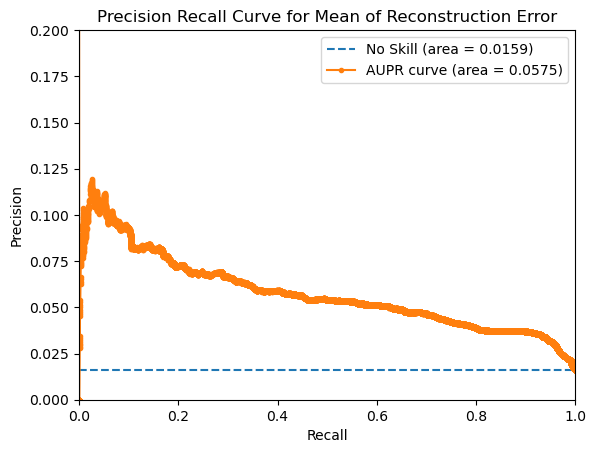

In [2]:

# Lets load the H%PY dataset into a pytorch dataset class.Please see 
# dataset_creator on how to generate the H5PY file. 
window_len = 8
stride = 1
fair_comparison = True


def full_pipeline(name, dset, window_len, fair_comparison, path, stride, modelpath):   


    Test_Dataset, test_dataloader, Train_Dataset, train_dataloader = create_pytorch_dataset(name, dset, path, window_len, fair_comparison, stride, TOD = 'Both')
    print('Train Dataloader - {}'.format(len(train_dataloader)))
    print('Test Dataloader - {}'.format(len(test_dataloader)))
    
    class Autoencoder(nn.Module):
        def __init__(self):
            super(Autoencoder, self).__init__()
            # first layer
            self.ec1 = nn.Conv3d(1, 32, (5, 3, 3), stride=1, padding=(2, 1, 1),)
            self.em1 = nn.MaxPool3d((1, 2, 2), return_indices=True)
            # second layer
            self.ec2 = nn.Conv3d(32, 16, (5, 3, 3), stride=1, padding=(2, 1, 1))
            self.em2 = nn.MaxPool3d((2, 2, 2), return_indices=True)
            # third layer
            self.ec3 = nn.Conv3d(16, 8, (5, 3, 3), stride=1, padding=(2, 1, 1))
            self.em3 = nn.MaxPool3d((2, 2, 2), return_indices=True)
            # encoding done, time to decode
            self.dc1 = nn.ConvTranspose3d(8, 16, (5, 3, 3), stride=1, padding=(2, 1, 1))
            self.dm1 = nn.MaxUnpool3d((2, 2, 2))
            # inverse of 2nd Conv
            self.dc2 = nn.ConvTranspose3d(16, 32, (5, 3, 3), stride=1, padding=(2, 1, 1))
            self.dm2 = nn.MaxUnpool3d((2, 2, 2))
            # final inverse
            self.dm3 = nn.MaxUnpool3d((1, 2, 2))
            self.dc3 = nn.ConvTranspose3d(32, 1, (5, 3, 3), stride=1, padding=(2, 1, 1))

        def forward(self, x):
            # *** start of encoder
            x = x.permute(1, 0, 2, 3, 4)  # reorder to have correct dimensions
            # (batch_size, chanels, depth, width, height)
            _ec1 = F.relu(self.ec1(x))
            _em1, i1 = self.em1(_ec1)
            #_ec1 = self.ed1(_ec1)
            # second layer
            _ec2 = F.relu(self.ec2(_em1))
            _em2, i2 = self.em2(_ec2)
            #_em2 = self.ed2(_em2)
            # third layer
            _ec3 = F.relu(self.ec3(_em2))
            _em3, i3 = self.em3(_ec3)
            # print("====== Encoding Done =========")
            _dm1 = self.dm1(_em3, i3, output_size=i2.size())
            _dc1 = F.relu(self.dc1(_dm1))
            _dm2 = self.dm2(_dc1, i2)
            _dc2 = F.relu(self.dc2(_dm2))
            _dm3 = self.dm3(_dc2, i1)
            re_x = torch.tanh(self.dc3(_dm3))
            return re_x

        

    # Now lets train our model

    # prepare for GPU training 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print('Device Used - ' + device)
    torch.cuda.empty_cache()

    # and lets set the hyperparameters! 

    dropout = 0.25
    learning_rate = 0.0002
    num_epochs = 20
    chunk_size = 64
    forward_chunk = 8 
    forward_chunk_size = 8 # this is smaller due to memory constrains 

    # select which model - you could load your own or put it in the function above 
    model = Autoencoder().to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    def train_model(filepath):
        print("Training has Begun")
        model.train()
        for epoch in range(num_epochs):
            val_loss = 0
            frame_stats = [] 
            window_stats = [] 
            for i, (sample, labels) in enumerate(train_dataloader):
                # ===================forward=====================
                sample = sample.to(device, dtype=torch.float)
                # split sample into smaller sizes due to GPU memory constraints
                chunks = torch.split(sample, chunk_size, dim=1)
                recon_vid = []

                for chunk in chunks:
                    output = model(chunk)
                    output = output.to(device).permute(1, 0, 2, 3, 4)
                    model.zero_grad()
                    loss = loss_fn(output, chunk)
                    recon_vid.append(output)
                    # ===================backward====================
                    # Getting gradients w.r.t. parameters
                    loss.backward()
                    # Updating parameters
                    optimizer.step()
                    # Clear gradients w.r.t. parameters
                    optimizer.zero_grad()
                    torch.cuda.empty_cache()
                
                if epoch == num_epochs-1:
                    output = torch.cat(recon_vid, dim=1)
                    # convert tensors to numpy arrays for easy manipluations
                    sample = sample.data.cpu().numpy()
                    output = output.data.cpu().numpy()
                    labels = labels.data.cpu().numpy()
                    frame_std, frame_mean, frame_labels, window_std, window_mean, window_labels = get_performance_metrics(sample, output, labels, window_len)
                    frame_stats.append([frame_mean, frame_std, frame_labels])
                    window_stats.append([window_mean, window_std, window_labels])
            
            if epoch == num_epochs-1:
                #get_total_performance_metrics(frame_stats, window_stats, window_len)
                recon_errors = []
                recon_labels = []
                for i in range(len(frame_stats)):
                    # print(i)
                    # this a single video metrics
                    frame_mean, frame_std, frame_labels = frame_stats[i]
                    recon_errors.append([frame_mean, frame_std])
                    recon_labels.append(frame_labels)    
                np.save(project_directory+"\Recon_Errors\\train_recon_errors_{}.npy".format(modality), recon_errors)
                np.save(project_directory+"\Recon_Errors\\train_recon_labels_{}.npy".format(modality), recon_labels)
    
            # ===================log========================
            print("epoch [{}/{}], loss:{:.4f}".format(epoch + 1, num_epochs, loss.item()))
            torch.save(model.state_dict(), filepath) # save the model each epoch at location filepath
            
        torch.cuda.empty_cache()
        print("Training has Completed")
        
   

    def foward_pass(path):
        model.load_state_dict(torch.load(path)) # load a saved model 
        model.eval()

        frame_stats = []
        window_stats = []

        with torch.no_grad():
            print("foward pass occuring")
            # just forward pass of model on test dataset
            for j, (sample, labels) in enumerate(test_dataloader):
                # foward pass to get output
                torch.cuda.empty_cache()
                sample = sample.to(device, dtype=torch.float)
                chunks = torch.split(sample, forward_chunk, dim=1)
                recon_vid = []
                for chunk in chunks:
                    output = model(chunk)
                    output = output.to(device).permute(1, 0, 2, 3, 4)
                    recon_vid.append(output)
                    torch.cuda.empty_cache()
                output = torch.cat(recon_vid, dim=1)
                # convert tensors to numpy arrays for easy manipluations
                sample = sample.data.cpu().numpy()
                output = output.data.cpu().numpy()
                labels = labels.data.cpu().numpy()


                frame_std, frame_mean, frame_labels, window_std, window_mean, window_labels = get_performance_metrics(sample, output, labels, window_len)
                frame_stats.append([frame_mean, frame_std, frame_labels])
                window_stats.append([window_mean, window_std, window_labels])
                
                #if j % 10 == 0:
                    #print(sample.shape)
                    #animate(sample[0, :, :, :, :], output[0, :, :, :, :], frame_mean, dset, start_time)
                
        return(frame_stats, window_stats)
    
    start_time = str(datetime.datetime.today().strftime("%Y-%m-%d-%H-%M-%S"))
    modality = (name + start_time)
    filepath = (project_directory+"\Models\\"+ modality + start_time)
    # comment out this call if you dont want to train a model
    train_model(filepath)

    # INSERT modelpath instead of filepath to use a specified pre trained model 
    frame_stats, window_stats = foward_pass(filepath)
    
    print(modality)
    get_total_performance_metrics(modality, frame_stats, window_stats, window_len)
    get_global_performance_metrics(modality, frame_stats, window_stats, window_len)
    
    
    return() 


# Datasets name used during file H5PY file creation
# list_of_datasets = ['ZED_RGB_T2','ZED_Depth_T2','ONI_Depth_T2','ONI_IR_T2', 'Thermal_T2', 'IP_T']
list_of_datasets = ['Thermal_T3'] 


# Directory of where files are stored for the camera
# list_of_files = ['TurncatedV1/ZED_RGB', 'TurncatedV1/ZED_Depth', 'TurncatedV1/ONI_Depth', 'TurncatedV1/ONI_IR', 'TurncatedV1/Thermal', 'TurncatedV1/IP', ] # 'EditsV1/IP',,"EditsV1/ONI_Depth", "EditsV1/ZED_Depth", "EditsV1/ZED_RGB", "EditsV1/Thermal",   "EditsV1/ONI_IR""EditsV1/IP",
list_of_files = ['Thermal']

# List of pre-trained model weight location if wanting to test trained model 
# list_of_models = ['x','x','x','x','x','x'] # after training - it will save them in the Models folder
list_of_models = ['x'] # after training - it will save them in the Models folder

script_directory=os.getcwd()
project_directory=os.path.dirname(script_directory)

for i in range(len(list_of_datasets)):
    modelpath = list_of_models[i]
    name = list_of_datasets[i]
    dset = list_of_files[i]
    path = "{}\H5PY\Data_set-{}-imgdim64x64.h5".format(project_directory,name) 
    full_pipeline(name, dset, window_len, fair_comparison, path, stride, modelpath)